<a href="https://colab.research.google.com/github/datacentertugaskuliah-coder/PraktikumDS/blob/main/Simulasi_Agen_RL_Randombaseline%2CDQN%2C_PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VERSI PAKET:
scikit-learn: 1.6.1
stable-baselines3: 2.3.2
gymnasium: 0.29.1
Loaded: bike_sharing_data/hour.csv
Shape: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


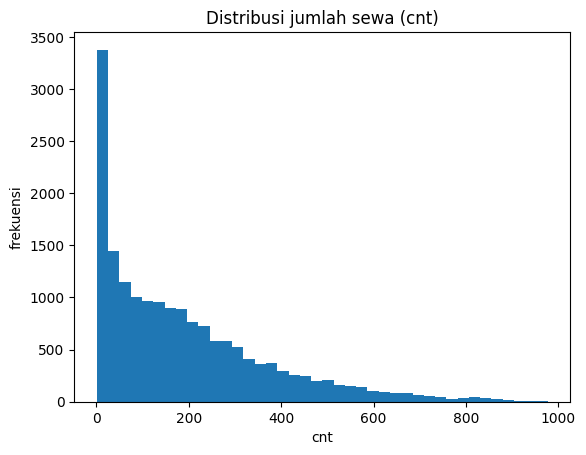

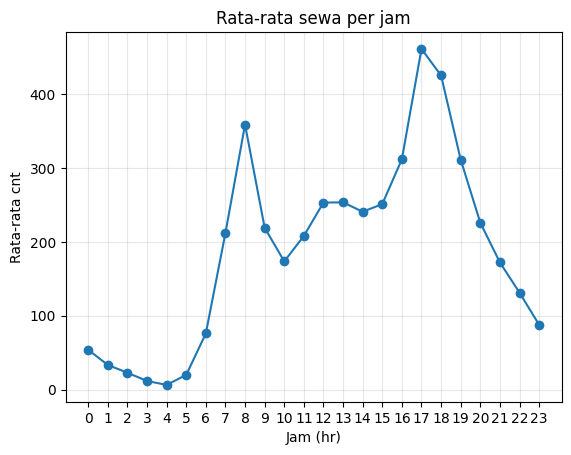

<Figure size 640x480 with 0 Axes>

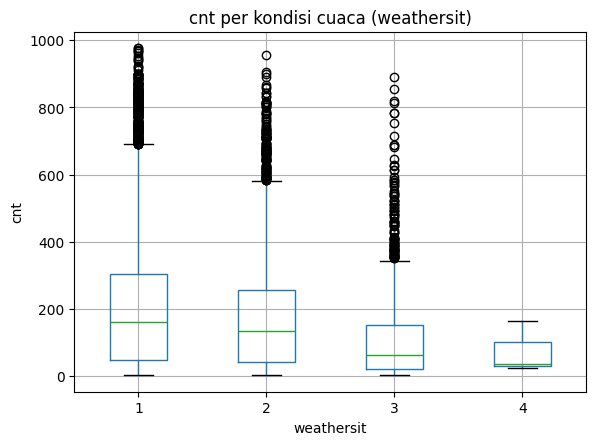


Baseline (HistGradientBoosting) - TimeSeries CV (3 folds):


,fold,MAE,RMSE,R2
0,1,47.243277,66.997968,0.767702
1,2,84.786210,120.421700,0.621645
2,3,65.609073,94.146185,0.816893


Rata-rata: {'fold': 2.0, 'MAE': 65.87951980617369, 'RMSE': 93.85528442603307, 'R2': 0.735413297401068}


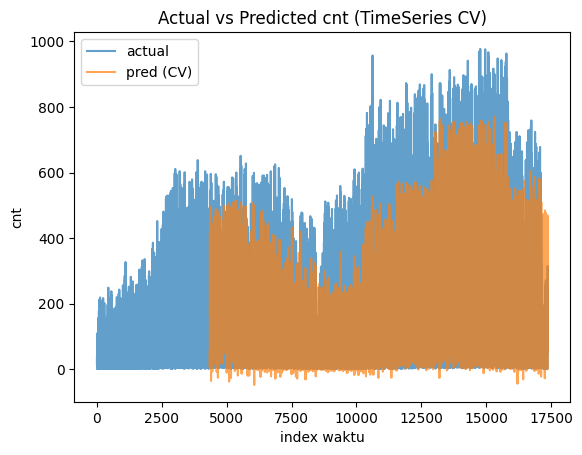

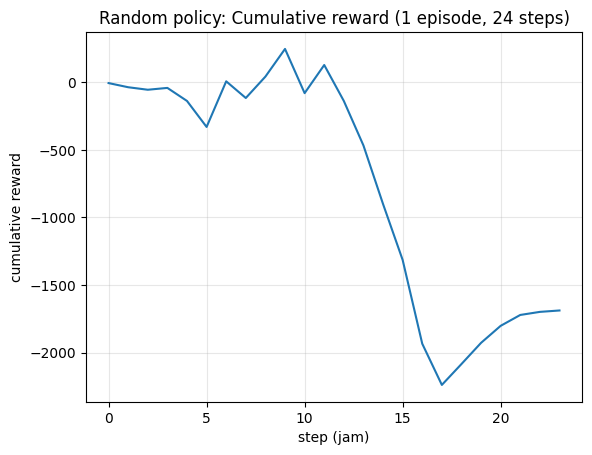

,promo,cap_level,capacity,base_demand,demand,realized,unmet,episode
0,1,0,58.0,3.0,3.18,3.18,0.00,NaN
1,4,2,244.0,5.0,6.20,6.20,0.00,NaN
2,3,1,142.0,7.0,8.26,8.26,0.00,NaN
3,1,4,563.1,31.0,32.86,32.86,0.00,NaN
4,4,0,58.0,112.0,138.88,58.00,80.88,NaN


DQN eval mean return: 3526.2956000000004 std: 2001.8403532915006


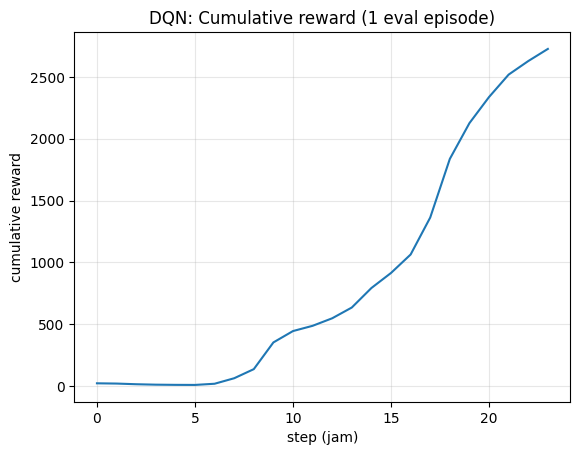

PPO eval mean return: 4601.946000000001 std: 569.4196259209898


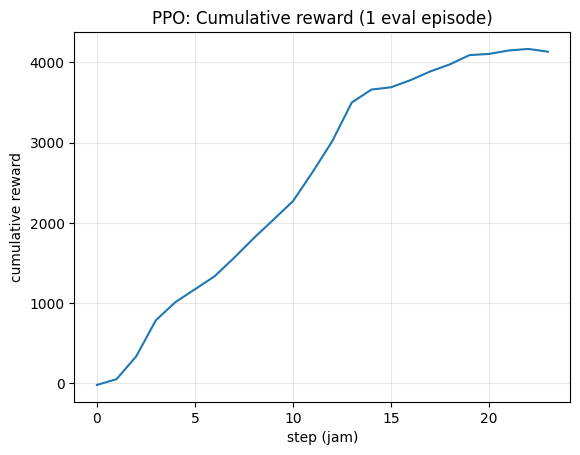


Perbandingan performa (return):


,model,mean_return,std_return
0,Random baseline,586.4540,1167.329674
1,DQN,3526.2956,2001.840353
2,PPO,4601.9460,569.419626


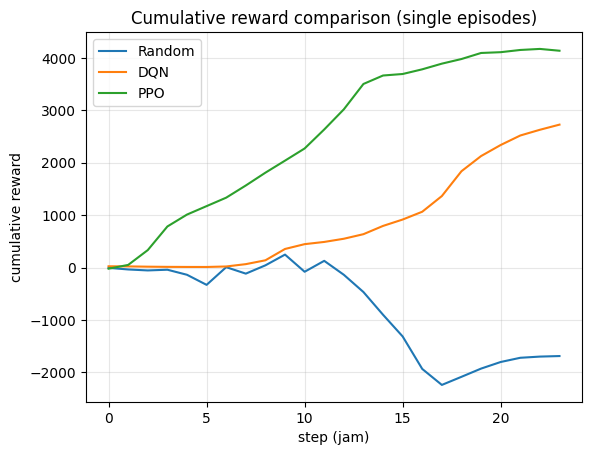


Preview kebijakan PPO (10 step):


,step,action_id,promo_level,cap_level,capacity,base_demand,demand_after_promo,realized,unmet
0,0,24,4,4,563.1,17.0,21.08,21.08,0.0
1,1,24,4,4,563.1,93.0,115.32,115.32,0.0
2,2,24,4,4,563.1,263.0,326.12,326.12,0.0
3,3,24,4,4,563.1,398.0,493.52,493.52,0.0
4,4,24,4,4,563.1,218.0,270.32,270.32,0.0
5,5,24,4,4,563.1,165.0,204.60,204.60,0.0
6,6,24,4,4,563.1,165.0,204.60,204.60,0.0
7,7,24,4,4,563.1,222.0,275.28,275.28,0.0
8,8,24,4,4,563.1,232.0,287.68,287.68,0.0
9,9,24,4,4,563.1,220.0,272.80,272.80,0.0


In [7]:
# ==========================================================
# Praktikum Data Science dan Machine Learning Berbasis Python dan UCI Repository
# Pembahasan: Pemrosesan Data dan Pembagian Latih–Uji (time-aware) + Simulasi Agen RL (cepat & rapi)
# Dataset: Bike Sharing Dataset (UCI Machine Learning Repository) - hour.csv
# UCI: https://archive.ics.uci.edu/dataset/275/bike%2Bsharing%2Bdataset
# Repo Referensi Praktikum: https://github.com/datacentertugaskuliah-coder/PraktikumDS.git
# Lingkungan: Google Colab (Python 3.12)
# ==========================================================


# -------- Cell 1: Install (kompatibel & stabil di Colab) --------
!pip -q install -U "gymnasium>=1.0.0" "stable-baselines3>=2.4.0" shimmy

# -------- Cell 2: Imports + suppress warnings --------
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module=r"jupyter_client\.session")

import os, zipfile, urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

# Transparansi versi
import sklearn, stable_baselines3, gymnasium
print("VERSI PAKET:")
print("scikit-learn:", sklearn.__version__)
print("stable-baselines3:", stable_baselines3.__version__)
print("gymnasium:", gymnasium.__version__)


# ==========================================================
# Tahap 1 — Akuisisi Data (UCI) + Pemrosesan Dasar
# ==========================================================

# -------- Cell 3: Download & Load hour.csv --------
url = "https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip"
zip_path = "bike_sharing_dataset.zip"
extract_dir = "bike_sharing_data"

if not os.path.exists(zip_path):
    urllib.request.urlretrieve(url, zip_path)

os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

data_dir = None
for root, dirs, files in os.walk(extract_dir):
    if "hour.csv" in files:
        data_dir = root
        break

if data_dir is None:
    raise FileNotFoundError("hour.csv tidak ditemukan setelah ekstraksi ZIP.")

hour_path = os.path.join(data_dir, "hour.csv")
df = pd.read_csv(hour_path)

# parsing & sorting (time-aware integrity)
df["dteday"] = pd.to_datetime(df["dteday"])
df = df.sort_values(["dteday", "hr"]).reset_index(drop=True)

print("Loaded:", hour_path)
print("Shape:", df.shape)
display(df.head())

# Audit ringkas
display(df.isna().sum().to_frame("missing").T)


# ==========================================================
# Tahap 2 — EDA
# ==========================================================

# -------- Cell 4: EDA Visual --------
plt.figure()
plt.hist(df["cnt"], bins=40)
plt.title("Distribusi jumlah sewa (cnt)")
plt.xlabel("cnt")
plt.ylabel("frekuensi")
plt.show()

hourly_mean = df.groupby("hr")["cnt"].mean()
plt.figure()
plt.plot(hourly_mean.index, hourly_mean.values, marker="o")
plt.title("Rata-rata sewa per jam")
plt.xlabel("Jam (hr)")
plt.ylabel("Rata-rata cnt")
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
df.boxplot(column="cnt", by="weathersit")
plt.title("cnt per kondisi cuaca (weathersit)")
plt.suptitle("")
plt.xlabel("weathersit")
plt.ylabel("cnt")
plt.show()


# ==========================================================
# Tahap 3 — Split Latih–Uji (TimeSeriesSplit) + Baseline Cepat
# Integritas: hindari leakage casual+registered (menjumlah jadi cnt)
# ==========================================================

# -------- Cell 5: Baseline model (cepat & kompatibel dense) --------
target = "cnt"
drop_cols = ["instant", "dteday", "casual", "registered", "cnt"]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].copy()
y = df[target].copy()

cat_cols = ["season","yr","mnth","hr","holiday","weekday","workingday","weathersit"]
num_cols = [c for c in feature_cols if c not in cat_cols]

# FIX sparse->dense secara kompatibel lintas versi sklearn
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

baseline = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.08,
    max_iter=150,   # diperkecil biar cepat
    random_state=42
)

pipe = Pipeline(steps=[("prep", preprocess), ("hgb", baseline)])

tscv = TimeSeriesSplit(n_splits=3)  # lebih cepat dari 5 folds

mae_list, rmse_list, r2_list = [], [], []
pred_all = np.full(len(df), np.nan)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    pred_all[test_idx] = y_pred

    mae = mean_absolute_error(y_test, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))  # kompatibel lintas versi
    r2 = r2_score(y_test, y_pred)

    mae_list.append(mae); rmse_list.append(rmse); r2_list.append(r2)

metrics_df = pd.DataFrame({"fold": range(1, len(mae_list)+1), "MAE": mae_list, "RMSE": rmse_list, "R2": r2_list})
print("\nBaseline (HistGradientBoosting) - TimeSeries CV (3 folds):")
display(metrics_df)
print("Rata-rata:", metrics_df.mean(numeric_only=True).to_dict())

plt.figure()
plt.plot(y.values, label="actual", alpha=0.7)
plt.plot(pred_all, label="pred (CV)", alpha=0.7)
plt.title("Actual vs Predicted cnt (TimeSeries CV)")
plt.xlabel("index waktu")
plt.ylabel("cnt")
plt.legend()
plt.show()


# ==========================================================
# Tahap 4 — Simulasi Agen RL (cepat + Monitor wrapper)
# ==========================================================

# -------- Cell 6: Environment RL --------
class BikeOpsEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(
        self,
        df,
        alpha=0.06,
        price=1.0,
        promo_cost=8.0,
        cap_cost=0.02,
        unmet_penalty=1.5,
        demand_cap_q=0.98,
        episode_len=24  # 1 hari -> cepat
    ):
        super().__init__()
        self.df = df.reset_index(drop=True)

        self.alpha = float(alpha)
        self.price = float(price)
        self.promo_cost = float(promo_cost)
        self.cap_cost = float(cap_cost)
        self.unmet_penalty = float(unmet_penalty)

        self.demand_cap = float(self.df["cnt"].quantile(demand_cap_q))
        self.episode_len = int(episode_len)

        self.obs_cols = ["season","yr","mnth","hr","holiday","weekday","workingday","weathersit","temp","hum","windspeed"]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(len(self.obs_cols),), dtype=np.float32)

        # Action 25: promo(0..4) x capacity_level(0..4)
        self.action_space = spaces.Discrete(25)

        # kapasitas berdasarkan kuantil demand historis (logis untuk "level kapasitas")
        base_caps = np.quantile(self.df["cnt"], [0.30, 0.50, 0.70, 0.85, 0.95])
        self.capacity_by_level = [float(x) for x in base_caps]

        self._t = 0
        self._start = 0

    def _get_obs(self, idx):
        return self.df.loc[idx, self.obs_cols].astype(np.float32).values

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        max_start = len(self.df) - self.episode_len - 1
        self._start = int(self.np_random.integers(0, max_start))
        self._t = 0
        return self._get_obs(self._start), {}

    def step(self, action):
        action = int(action)
        promo = int(action // 5)
        cap_level = int(action % 5)
        capacity = self.capacity_by_level[cap_level]

        idx = self._start + self._t
        base_demand = float(self.df.loc[idx, "cnt"])

        # promo menaikkan demand secara terkendali
        demand = base_demand * (1.0 + self.alpha * promo)
        demand = min(demand, self.demand_cap)

        realized = min(demand, capacity)
        unmet = max(0.0, demand - realized)

        reward = (
            self.price * realized
            - self.promo_cost * promo
            - self.cap_cost * capacity
            - self.unmet_penalty * unmet
        )

        self._t += 1
        terminated = (self._t >= self.episode_len)
        truncated = False

        obs_idx = (self._start + self._t) if not terminated else (self._start + self._t - 1)
        obs = self._get_obs(obs_idx)

        info = {
            "promo": promo, "cap_level": cap_level, "capacity": capacity,
            "base_demand": base_demand, "demand": demand, "realized": realized, "unmet": unmet
        }
        return obs, float(reward), terminated, truncated, info


def run_episode(env, policy=None, deterministic=True):
    obs, _ = env.reset()
    rewards, infos, actions = [], [], []
    done = False
    while not done:
        if policy is None:
            a = env.action_space.sample()
        else:
            a, _ = policy.predict(obs, deterministic=deterministic)
            a = int(a)
        obs, r, term, trunc, info = env.step(a)
        done = term or trunc
        rewards.append(r); infos.append(info); actions.append(a)
    return np.array(rewards), pd.DataFrame(infos), np.array(actions)


# -------- Cell 7: Random baseline --------
env_rand = Monitor(BikeOpsEnv(df))  # dibungkus Monitor untuk konsistensi
rewards_rand, info_rand, act_rand = run_episode(env_rand)

plt.figure()
plt.plot(np.cumsum(rewards_rand))
plt.title("Random policy: Cumulative reward (1 episode, 24 steps)")
plt.xlabel("step (jam)")
plt.ylabel("cumulative reward")
plt.grid(True, alpha=0.3)
plt.show()

display(info_rand.head())


# -------- Cell 8: DQN --------
train_env_dqn = Monitor(BikeOpsEnv(df))
dqn = DQN(
    "MlpPolicy",
    train_env_dqn,
    learning_rate=1e-3,
    buffer_size=15_000,
    learning_starts=500,
    batch_size=64,
    gamma=0.99,
    train_freq=4,
    target_update_interval=500,
    verbose=0,
)
dqn.learn(total_timesteps=12_000)  # kecil -> cepat

eval_env_dqn = Monitor(BikeOpsEnv(df))
mean_dqn, std_dqn = evaluate_policy(dqn, eval_env_dqn, n_eval_episodes=5, deterministic=True)
print("DQN eval mean return:", mean_dqn, "std:", std_dqn)

rewards_dqn, info_dqn, act_dqn = run_episode(Monitor(BikeOpsEnv(df)), policy=dqn, deterministic=True)
plt.figure()
plt.plot(np.cumsum(rewards_dqn))
plt.title("DQN: Cumulative reward (1 eval episode)")
plt.xlabel("step (jam)")
plt.ylabel("cumulative reward")
plt.grid(True, alpha=0.3)
plt.show()


# -------- Cell 9: PPO  --------
train_env_ppo = Monitor(BikeOpsEnv(df))
ppo = PPO(
    "MlpPolicy",
    train_env_ppo,
    learning_rate=3e-4,
    n_steps=256,
    batch_size=128,
    gamma=0.99,
    gae_lambda=0.95,
    ent_coef=0.0,
    verbose=0,
)
ppo.learn(total_timesteps=15_000)  # kecil -> cepat

eval_env_ppo = Monitor(BikeOpsEnv(df))
mean_ppo, std_ppo = evaluate_policy(ppo, eval_env_ppo, n_eval_episodes=5, deterministic=True)
print("PPO eval mean return:", mean_ppo, "std:", std_ppo)

rewards_ppo, info_ppo, act_ppo = run_episode(Monitor(BikeOpsEnv(df)), policy=ppo, deterministic=True)
plt.figure()
plt.plot(np.cumsum(rewards_ppo))
plt.title("PPO: Cumulative reward (1 eval episode)")
plt.xlabel("step (jam)")
plt.ylabel("cumulative reward")
plt.grid(True, alpha=0.3)
plt.show()


# ==========================================================
# Tahap 5 — Ringkasan Evaluasi (Tabel + Grafik)
# ==========================================================

# -------- Cell 10: Comparison table --------
random_returns = []
for _ in range(5):  # sedikit episode -> cepat
    r, _, _ = run_episode(Monitor(BikeOpsEnv(df)), policy=None)
    random_returns.append(r.sum())

result = pd.DataFrame([
    {"model": "Random baseline", "mean_return": float(np.mean(random_returns)), "std_return": float(np.std(random_returns))},
    {"model": "DQN", "mean_return": float(mean_dqn), "std_return": float(std_dqn)},
    {"model": "PPO", "mean_return": float(mean_ppo), "std_return": float(std_ppo)},
])

print("\nPerbandingan performa (return):")
display(result)

plt.figure()
plt.plot(np.cumsum(rewards_rand), label="Random")
plt.plot(np.cumsum(rewards_dqn), label="DQN")
plt.plot(np.cumsum(rewards_ppo), label="PPO")
plt.title("Cumulative reward comparison (single episodes)")
plt.xlabel("step (jam)")
plt.ylabel("cumulative reward")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# -------- Cell 11: Interpretability (ringkas, 10 step PPO) --------
def decode_action(a):
    return int(a // 5), int(a % 5)

rows = []
for i in range(min(10, len(act_ppo))):
    promo, cap_level = decode_action(act_ppo[i])
    rows.append({
        "step": i,
        "action_id": int(act_ppo[i]),
        "promo_level": promo,
        "cap_level": cap_level,
        "capacity": float(info_ppo.loc[i, "capacity"]),
        "base_demand": float(info_ppo.loc[i, "base_demand"]),
        "demand_after_promo": float(info_ppo.loc[i, "demand"]),
        "realized": float(info_ppo.loc[i, "realized"]),
        "unmet": float(info_ppo.loc[i, "unmet"]),
    })

print("\nPreview kebijakan PPO (10 step):")
display(pd.DataFrame(rows))
